### Data modeling of request orders

In [1]:
# Importing all the necessary libraries
import numpy as np              # Numerical array manipulation
import matplotlib.pyplot as plt # Plotting capabilities
import pymc3 as pm              # Python Monte Carlo Markov Chain package
import functionES as es         # Customized functions for this project
import seaborn as sns           # Fancy plot visualizations
import arviz as az
import pyodbc, datetime
import pandas as pd
# import theano.tensor as tt

#  Loading data
datos = es.importing_data('OTs_NoDet.sql', 15, 1)

# Filtering data to keep the request orders finished
# datosObservados = es.process_filter(datos)# Advanced process mining filtering

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# datos.head()
datos['TiempoAtencion'] = round((datos.TiempoEstatus-datos.TiempoAltaOt).dt.total_seconds()/3600)

In [3]:
datosObservados = datos.sort_values('TiempoAltaOt', ascending=True)
count_obs = len(datosObservados)# How many observations we have

In [4]:
# datos.to_csv("datosTest.csv", index = False, header = True)
datosObservados.shape[0]

4889

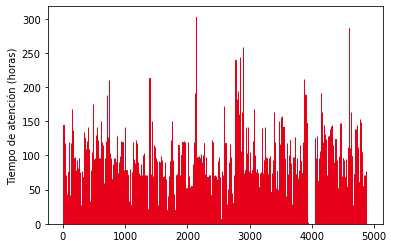

In [5]:
f = plt.figure()
ax1 = f.add_subplot(1,1,1)

ax1.bar(np.arange(len(datos)),datos.TiempoAtencion, edgecolor = "#E60018")
ax1.yaxis.set_label_text("Tiempo de atención (horas)")
plt.show()

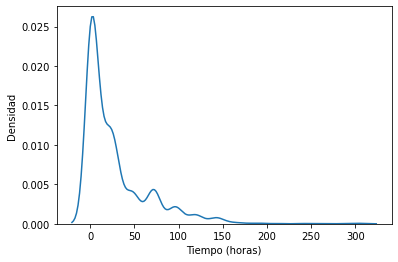

In [6]:
sns.kdeplot(datosObservados.TiempoAtencion)
plt.xlabel("Tiempo (horas)")
plt.ylabel("Densidad")
plt.show()

In [7]:
datosObservados.describe()

,IdOT,TiempoAtencion
count,4.889000e+03,4889.000000
mean,1.474304e+06,28.175905
std,2.413917e+03,37.397002
min,1.470245e+06,0.000000
25%,1.472266e+06,1.000000
50%,1.474220e+06,15.000000
75%,1.476274e+06,42.000000
max,1.478986e+06,303.000000


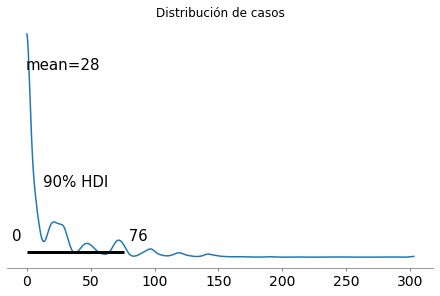

In [8]:
pm.plot_posterior(datos.TiempoAtencion.to_numpy(), hdi_prob = 0.9)
plt.title("Distribución de casos")
plt.show()

In [9]:
# Generating Model context
with pm.Model() as model:
    alpha = 1.0/(datosObservados.TiempoAtencion).mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
#     lambda_2 = pm.Exponential("lambda_2", alpha)

#     tau = pm.DiscreteUniform("tau", lower=0, upper=count_obs-1)

# Generating lambdas (two because at some point, lambda changes its value)
with model:
    idx = np.arange(count_obs)
    lambda_ = lambda_1 #pm.math.switch(tau > idx, lambda_1, lambda_2)
    
# Generation Observation distribution
with model:
    observation = pm.Poisson("obs", lambda_, observed = datosObservados.TiempoAtencion)
    
# Generating simulations
with model:
    step = pm.Metropolis()
#     start = pm.find_MAP()
    trace = pm.sample(1000, tune = 500, step = step, progressbar = True)#, start = start)
    
lambda_1_samples = trace['lambda_1']
# lambda_2_samples = trace['lambda_2']
# tau_samples = trace['tau']

<ipython-input-9-7d199248b066>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune = 500, step = step, progressbar = True)#, start = start)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda_1]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2223 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [10]:
# az.plot_trace(trace)
# plt.show()

In [11]:
# pm.summary(trace)

In [12]:
with model:
    posterior_predictive= pm.fast_sample_posterior_predictive(trace)

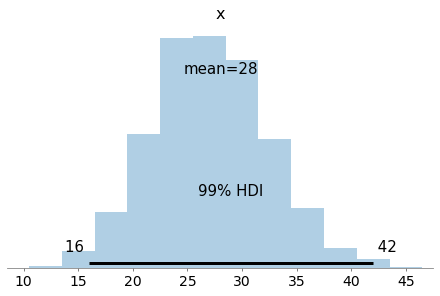

In [13]:
az.plot_posterior(posterior_predictive["obs"][:,0], hdi_prob = 0.99)
plt.show()

In [14]:
IQRx1_5 = 1.5*(np.quantile(posterior_predictive["obs"][:,0], 0.75)-np.quantile(posterior_predictive["obs"][:,0], 0.25))
prediccion = pd.DataFrame(np.array([[np.quantile(posterior_predictive["obs"][:,0], 0.25)-IQRx1_5
                          , np.quantile(posterior_predictive["obs"][:,0], 0.25)
                          , np.quantile(posterior_predictive["obs"][:,0], 0.50)
                          , np.quantile(posterior_predictive["obs"][:,0], 0.75)
                          , np.quantile(posterior_predictive["obs"][:,0], 0.75)+IQRx1_5]]), 
                          columns = ["Min_90", "Q1", "Q2", "Q3", "Max_90"])
prediccion["FechaPrediccion"]= datetime.datetime.today()

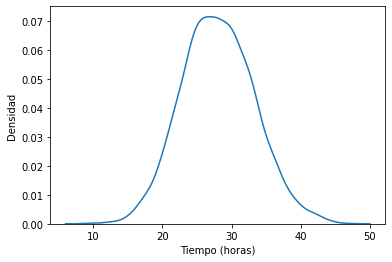

In [15]:
sns.kdeplot(posterior_predictive["obs"][:,0])
plt.xlabel("Tiempo (horas)")
plt.ylabel("Densidad")
plt.show()

In [16]:
prediccion

,Min_90,Q1,Q2,Q3,Max_90,FechaPrediccion
0,12.0,24.0,28.0,32.0,44.0,2021-05-06 13:38:19.482070
